BU KODU GÖZDEN GEÇİR Bİ ELLE VE BÖLÜMLERE AYIR FALAN FİLAN

In [33]:
import pandas as pd 
#Data reading, manipulation and analysis operations.

import numpy as np
#Numerical operations and matrix operations.

import matplotlib.pyplot as plt
#Graphic drawing.

from sklearn.preprocessing import MinMaxScaler
#MinMaxScaler: Used to scale data. It enables the LSTM model to 
# learn better by transforming time series data into a range between 0 and 1.

from tensorflow.keras.models import Sequential
#Sequential: Allows layers to be created in a sequential model structure.

from tensorflow.keras.layers import LSTM, Dense, Dropout
#LSTM: A neural network layer suitable for time series data with long-short-term memory structures. It is widely used in time series forecasting.
#Dense: Fully connected layer; It is used in the output layer of the model.
#Dropout: A regularization method that temporarily disables some random neurons to prevent overfitting.

from tensorflow.keras.optimizers import Adam
#Adam: An efficient and widely used optimization algorithm. It provides better learning by dynamically adjusting the learning speed.
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
#mean_squared_error (MSE): Error metric measured by averaging the squares of the error.
#mean_absolute_error (MAE): Error metric calculated by averaging the absolute differences between the actual value and the prediction.
#mean_absolute_percentage_error (MAPE): Expresses the error rate as a percentage; It is used to evaluate the accuracy of predictions.

from tensorflow.keras.callbacks import EarlyStopping
#EarlyStopping: A method used to prevent overfitting of the model. If the validation loss does not improve during training, it automatically stops training.

In [34]:
data = pd.read_csv("world_economic_indicators.csv")
#pd.read_csv(): This function reads the data file in CSV format with the pandas library and stores it as a DataFrame object.
#data: Data is kept in a variable called data. This variable contains data in DataFrame format and can be processed with pandas commands.
#Purpose: To perform analysis and forecasting operations by loading the economic indicators in the world_economic_indicators.csv file into the program.

print(data.head(5))
#data.head(5): Shows the first 5 lines of the DataFrame. This allows us to quickly see the overall structure of the data and the type of data each column contains.

print(data.info())
#data.info(): This function provides basic information about the DataFrame.


                  Country Name Country Code  Year  \
0                        Aruba          ABW  1960   
1  Africa Eastern and Southern          AFE  1960   
2                  Afghanistan          AFG  1960   
3   Africa Western and Central          AFW  1960   
4                       Angola          AGO  1960   

   Personal remittances, received (% of GDP)  \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                                        NaN   
4                                        NaN   

   Unemployment, total (% of total labor force)  GDP (current US$)_x  \
0                                           NaN                  NaN   
1                                           NaN         2.112502e+10   
2                                           NaN         5.377778e+08   
3                                           NaN         1.044764e+10   
4                               

In [35]:
# data[['Country Name', 'Year', ...]]: In this step, only the columns required for analysis are selected from the data set.

data_cleaned = data[['Country Name', 'Year', 
                     'Unemployment, total (% of total labor force)', 
                     'GDP (current US$)_x', 'GDP growth (annual %)_x']]

# data_cleaned['Country Name'] == 'Germany': This expression selects only rows with "Germany" in the "Country Name" column.
#data_cleaned[...]: The data_cleaned table contains only data for Germany.
germany_data = data_cleaned[data_cleaned['Country Name'] == 'Germany']

# germany_data[['Year', 'GDP growth (annual %)_x']]: Only the "Year" and "GDP growth (annual %)_x" columns are taken from the German data.
#.fill(): Performs forward filling. If there is a missing value, it fills it with the previous valid value.
#.dropna(): Completely deletes the remaining missing values.
germany_data_filled = germany_data[['Year', 'GDP growth (annual %)_x']].ffill().dropna()

# set_index('Year'): Sets the "Year" column as the index.
#inplace=True: Permanently applies the operation to the original data.
germany_data_filled.set_index('Year', inplace=True)

# germany_data_filled['GDP growth (annual %)_x'].values: Retrieves Germany's annual GDP growth rate column as a NumPy array. This creates a data set ready for modelling.
#Purpose: To take GDP growth rate values ​​as a one-dimensional data set that can be used in the model.
gdp_growth = germany_data_filled['GDP growth (annual %)_x'].values

In [36]:
# MinMaxScaler(feature_range=(0, 1)): MinMaxScaler is used to scale the data to a specific range (in this case, between 0 and 1).
# This allows the model to learn the data more efficiently and ensures consistency across different data scales.
scaler = MinMaxScaler(feature_range=(0, 1))

# fit_transform(gdp_growth.reshape(-1, 1)): MinMaxScaler scales the GDP growth data between 0 and 1.
# gdp_growth.reshape(-1, 1) reshapes the data into a 2D array (with one value per row).
# The scaled data is then stored in the variable gdp_growth_scaled.
gdp_growth_scaled = scaler.fit_transform(gdp_growth.reshape(-1, 1))

# Define the training and test data split: 80% of the data will be used for training, and 20% for testing.
train_size = int(len(gdp_growth_scaled) * 0.8)  # Calculate 80% of the total data length.

# Training data: The first 80% of the data is selected as the training dataset.
train_data = gdp_growth_scaled[:train_size]

# Test data: The remaining 20% of the data is selected as the test dataset.
test_data = gdp_growth_scaled[train_size:]


In [37]:
# Split the data into X and y (we will use the past 5 years for LSTM)
# create_dataset: This function creates X (input) and y (output) datasets using a specified time step (5 years of historical data).
def create_dataset(data, time_step=5):
    X, y = [], []
    # Fill X and y arrays using data from the past time_step years.
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])  # X: Each sample contains time_step data points.
        y.append(data[i + time_step, 0])      # y: Each sample contains the target value for the next time step.
    return np.array(X), np.array(y)

time_step = 5  # Using the past 5 years of data to make predictions.

# Create training data
X_train, y_train = create_dataset(train_data, time_step)

# Create test data
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input for LSTM (samples, time steps, features)
# reshape: Reshaping X_train and X_test into the required format for LSTM: (number of samples, time steps, number of features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [38]:
# Building the LSTM Model
model = Sequential()  # Define a sequential model structure.

# Adding LSTM layers
model.add(LSTM(units=150, return_sequences=True))  # First LSTM layer with 150 units
model.add(Dropout(0.15))  # Add dropout of 15% to reduce overfitting
model.add(LSTM(units=100, return_sequences=True))  # Second LSTM layer with 100 units
model.add(Dropout(0.15))  # Add dropout of 15% to reduce overfitting
model.add(LSTM(units=50, return_sequences=False))  # Third LSTM layer with 50 units

# Output layer
model.add(Dense(units=1))  # Output layer with 1 unit, providing the final prediction

# Compiling the model
optimizer = Adam(learning_rate=0.001)  # Use the Adam optimizer with a learning rate of 0.001
model.compile(optimizer=optimizer, loss='mean_squared_error')  # Set loss function as Mean Squared Error (MSE)

# Adding EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)  
# EarlyStopping: Stops training if 'val_loss' does not improve for a specified number of epochs.
# patience=15 means training stops if no improvement occurs for 15 consecutive epochs.

# Training the model
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stop])
# Model training: Set to run for 200 epochs with a batch size of 16.
# validation_data allows evaluation on the test set, and early stopping is enabled via early_stop callback.


Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - loss: 0.5192 - val_loss: 0.2741
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3439 - val_loss: 0.1391
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1781 - val_loss: 0.0436
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0469 - val_loss: 0.1235
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0845 - val_loss: 0.0627
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0320 - val_loss: 0.0433
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0464 - val_loss: 0.0476
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0619 - val_loss: 0.0462
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0580 - val_loss: 0.0430
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0437 - val_loss: 0.0509
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0360 - val_loss: 0.0687
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0532 - val_l

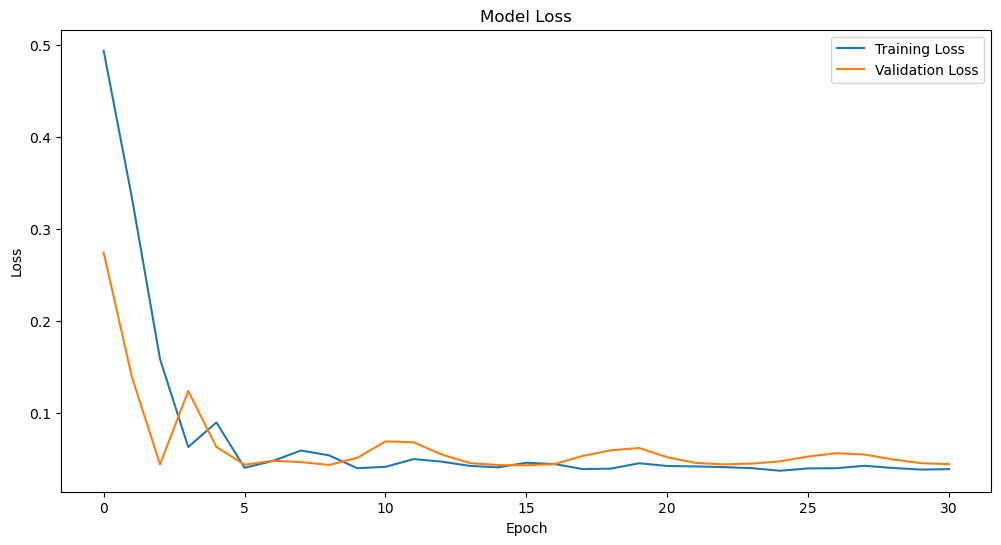

In [39]:
# Visualize the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Plot the training loss over epochs
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot the validation loss over epochs
plt.title('Model Loss')  # Title of the plot
plt.xlabel('Epoch')  # Label for the x-axis (epochs)
plt.ylabel('Loss')  # Label for the y-axis (loss value)
plt.legend()  # Display the legend to differentiate between training and validation loss
plt.show()  # Show the plot


In [40]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Rescale the predicted and actual data back to the original scale
# This allows us to interpret the results in the original GDP growth rate units.
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast from 2022 to 2030
last_known_value = gdp_growth_scaled[-time_step:]  # The last 5 years of data
forecast_years = 2030 - 2022  # Number of years to forecast
forecasted_values = []  # Initialize an empty list to store forecasted values


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


In [41]:
# Adjust the first prediction to start from 2022
for i in range(forecast_years):
    # Predict the next value using the last known 5 years of data
    prediction = model.predict(last_known_value.reshape(1, time_step, 1))
    forecasted_values.append(prediction[0, 0])  # Append the predicted value to the forecasted values list
    # Update last_known_value by appending the new prediction and removing the oldest value
    last_known_value = np.append(last_known_value[1:], prediction, axis=0)

# Rescale the forecasted values back to the original scale
forecasted_values_rescaled = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

# Include the value for 2022 by adjusting the forecasted values array
forecasted_values_rescaled = np.insert(forecasted_values_rescaled, 0, scaler.inverse_transform(last_known_value[0].reshape(1, -1)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


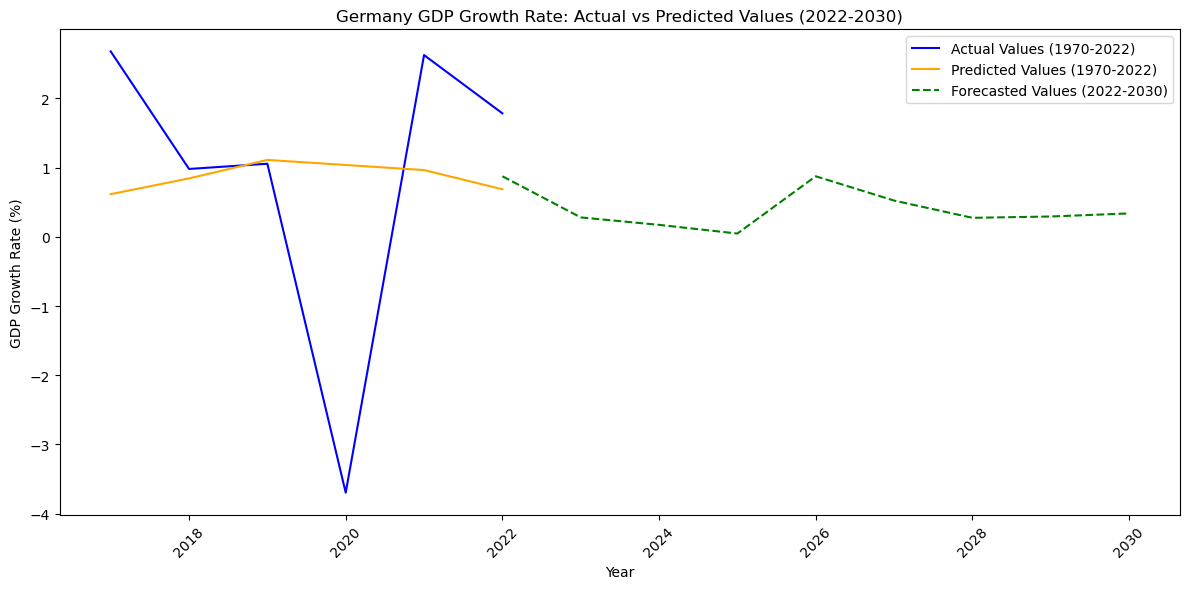

In [42]:
# Create a figure for the plot with specified size
plt.figure(figsize=(12, 6))

# Plot the actual values (from the test set, starting after the training data)
plt.plot(germany_data_filled.index[train_size + time_step:], y_test_rescaled, label="Actual Values (1970-2022)", color='blue')

# Plot the predicted values (from the model predictions, starting after the training data)
plt.plot(germany_data_filled.index[train_size + time_step:], y_pred_rescaled, label="Predicted Values (1970-2022)", color='orange')

# Plot the forecasted values for the future (from 2022 to 2030)
future_years = np.arange(2022, 2031)  # The forecast will start from the year 2022
plt.plot(future_years, forecasted_values_rescaled, label="Forecasted Values (2022-2030)", color='green', linestyle='--')

# Add labels to the axes
plt.xlabel('Year')
plt.ylabel('GDP Growth Rate (%)')

# Add a title to the plot
plt.title('Germany GDP Growth Rate: Actual vs Predicted Values (2022-2030)')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend to the plot
plt.legend()

# Adjust the layout to avoid overlapping elements
plt.tight_layout()

# Display the plot
plt.show()


In [43]:
# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

# Print the RMSE value
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 2.2608764966466035


In [44]:
# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

# Print the MAE value
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 1.62494133954657


In [45]:
# Calculate MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)

# Print the MAPE value
print(f"Mean Absolute Percentage Error (MAPE): {mape}")


Mean Absolute Percentage Error (MAPE): 0.5815696429064118


In [46]:
# Calculate the accuracy (1 - MAPE)
accuracy = (1 - mape) * 100

# Print the accuracy value as a percentage
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 41.84%


In [47]:
# Print the predictions and actual values
print("\nPredictions and Actual Values:")

# Loop through the first 10 data points (or less if there are fewer values)
for i in range(min(10, len(y_test_rescaled))):  # Ensure we don't go out of bounds
    print(f"Year: {germany_data_filled.index[train_size + time_step + i]}, Actual: {y_test_rescaled[i][0]:.2f}, Prediction: {y_pred_rescaled[i][0]:.2f}")



Predictions and Actual Values:
Year: 2017, Actual: 2.68, Prediction: 0.62
Year: 2018, Actual: 0.98, Prediction: 0.84
Year: 2019, Actual: 1.06, Prediction: 1.11
Year: 2020, Actual: -3.70, Prediction: 1.04
Year: 2021, Actual: 2.63, Prediction: 0.97
Year: 2022, Actual: 1.79, Prediction: 0.69
